<a href="https://colab.research.google.com/github/Rishit605/tweet-text-analysis/blob/main/Actual_Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Loading Kaggle API ##
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
cd /content/dataset

/content/dataset


In [ ]:
! kaggle datasets download -d kazanova/sentiment140
! unzip /content/dataset/sentiment140.zip

 79% 64.0M/80.9M [00:00<00:00, 212MB/s]
100% 80.9M/80.9M [00:00<00:00, 218MB/s]
Archive:  /content/dataset/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
cd ..

/content


In [ ]:
! pip install tensorflow==2.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 668.6 MB 398 kB/s
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
    Uninstalling tensorflow-2.8.0+zzzcolab20220506162203:
      Successfully uninstalled tensorflow-2.8.0+zzzcolab20220506162203


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
tf.debugging.set_log_device_placement(True)

# NLTK
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

import gensim

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Setting**

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# **Dataset details**

*   **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive).

*   **ids**: The id of the tweet ( 2087).

*   **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

*   **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.

*   **user**: the user that tweeted (robotickilldozr)

*   **text**: the text of the tweet (Lyx is cool)

In [ ]:
dataset_path = '/content/dataset/training.1600000.processed.noemoticon.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/dataset/training.1600000.processed.noemoticon.csv


In [ ]:
print("Dataset size:", len(df))
df.head()

Dataset size: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# **Mapping Sentiment Labels to string**

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
# import time

# %time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

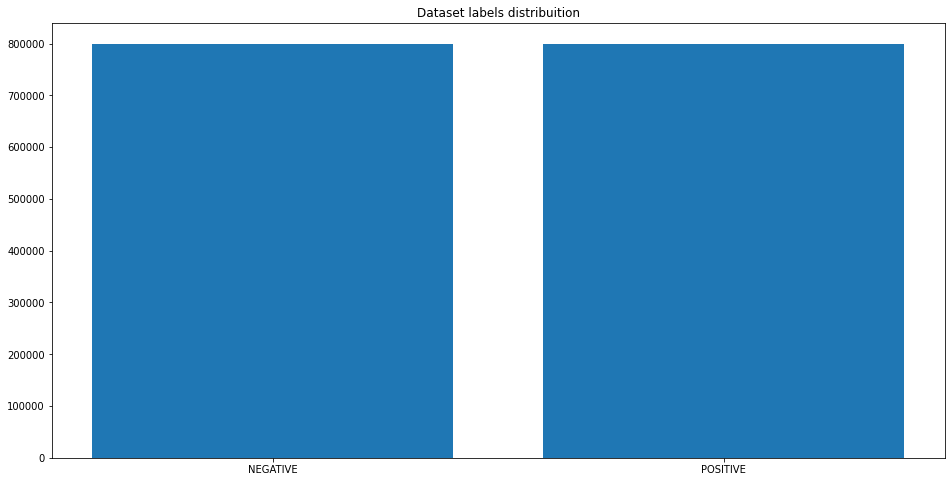

In [ ]:
from collections import Counter

target_count = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_count.keys(), target_count.values())
plt.title("Dataset labels distribuition")

# **Pre-Processing**

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
# %time
# df.text = df.text.apply(lambda x: preprocess(x))

# **Train Test Split**

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


# **Word2Vec**

In [ ]:
documents = [_text.split() for _text in df_train.text] 

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 59839


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(396113702, 539612384)

In [ ]:
w2v_model.most_similar("good")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('great', 0.753255307674408),
 ('nice', 0.6432521343231201),
 ('goood', 0.6259602904319763),
 ('gd', 0.5972440838813782),
 ('rough', 0.5949575901031494),
 ('gooood', 0.5907298922538757),
 ('fantastic', 0.5819651484489441),
 ('bad', 0.5760329961776733),
 ('goooood', 0.5738552808761597),
 ('fab', 0.569416344165802)]

In [ ]:
w2v_model.most_similar("bad")
# self.wv.most_similar("bad")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bad,', 0.6417614221572876),
 ('bad.', 0.6213996410369873),
 ('bad..', 0.6163977384567261),
 ('good', 0.5760329961776733),
 ('bad...', 0.5721091032028198),
 ('horrible', 0.571735143661499),
 ('terrible', 0.5651256442070007),
 ('bad!', 0.5415750741958618),
 ('shitty', 0.4950791895389557),
 ('bad....', 0.4942411482334137)]

# **Tokenize Text**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 594849


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


# **Embedding Layer**

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(594849, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          178454700 
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 178,615,201
Trainable params: 160,501
Non-trainable params: 178,454,700
_________________________________________________________________


In [ ]:
model.compile (optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 677s 600ms/step - loss: 0.4800 - accuracy: 0.7682 - val_loss: 0.4221 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - 622s 553ms/step - loss: 0.4410 - accuracy: 0.7933 - val_loss: 0.4148 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - 615s 547ms/step - loss: 0.4298 - accuracy: 0.8002 - val_loss: 0.4059 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - 616s 547ms/step - loss: 0.4244 - accuracy: 0.8034 - val_loss: 0.4007 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - 611s 543ms/step - loss: 0.4208 - accuracy: 0.8055 - val_loss: 0.3996 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - 611s 543ms/step - loss: 0.4184 - accuracy: 0.8067 - val_loss: 0.3965 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 7/8
1125/1125 [===================

# **Evaluating**

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 34s 108ms/step - loss: 0.3954 - accuracy: 0.8233

ACCURACY: 0.8232718706130981
LOSS: 0.3953756093978882


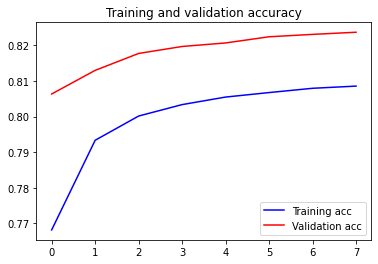

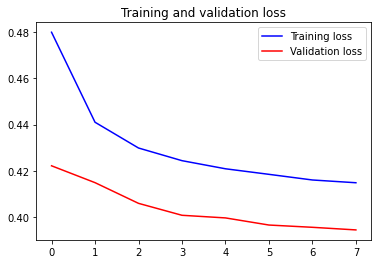

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
cd /content/dataset/Baja Quora Reviews

/content/dataset/Baja Quora Reviews


In [ ]:
! kaggle datasets download -d rishi605/bajaj-quora-reviews

  0% 0.00/39.0k [00:00<?, ?B/s]
100% 39.0k/39.0k [00:00<00:00, 36.2MB/s]


In [ ]:
! unzip /content/dataset/BajajReviews/bajaj-quora-reviews.zip

Archive:  /content/dataset/BajajReviews/bajaj-quora-reviews.zip
  inflating: What is your review of Bajaj Finserv_ - Quora.csv  
  inflating: clean_data.csv          


# **Predict**

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
import time

def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
df2_test = pd.read_csv('/content/dataset/BajajReviews/clean_data.csv')
df2_test

,Name,text
0,Anusha Reddy,Bajaj finserve is like my shitttt….. the promo...
1,Prashant Mishra,Be careful about bajaj finserve home loan I sw...
2,Balaji Chintu,I would say they are worst than the local fina...
3,Tanmay Upadhyaya,This is regarding my following LANs with BHFL.
4,Utkarsh,Never in your mind think about taking loan fro...
...,...,...
79,Bharat Patkar,You can Buy any thing with this card be it a g...
80,Harish Verma,"Yes,"
81,David Jose,"Longer the tenure, higher the effective intere..."
82,Vinay Raghavendran,Disclaimer: I have previously worked with Baja...


In [ ]:
predict('I dont have good experience with the Bajaj Finserv EMI Card')

{'elapsed_time': 0.22119641304016113,
 'label': 'NEGATIVE',
 'score': 0.04777635633945465}

# **Confusion MAtrix**

In [ ]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 22s 537ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

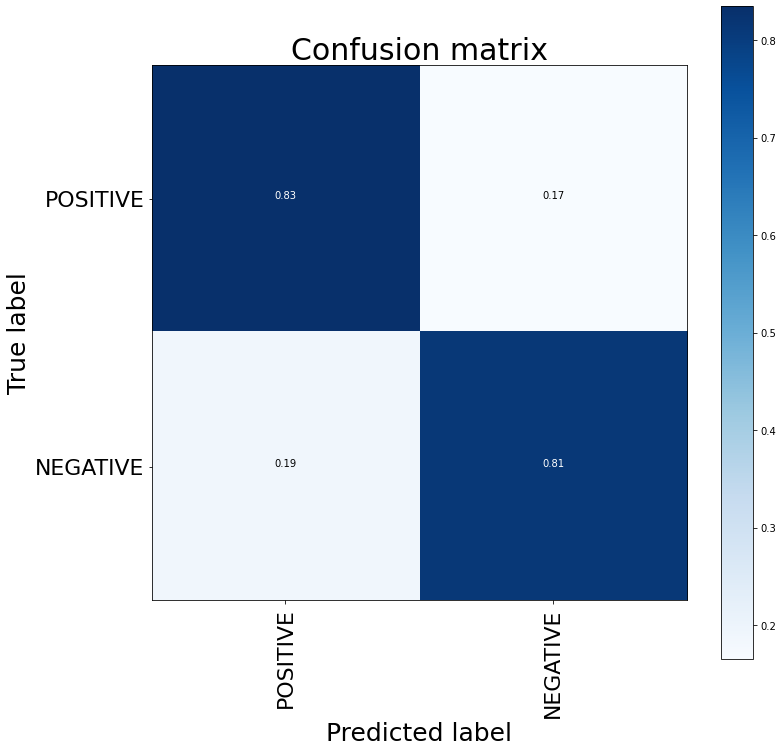

In [ ]:
import itertools

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.83      0.82    159494
    POSITIVE       0.83      0.81      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



# **Accuracy**

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.823271875

# **Saving the Model**

In [ ]:
cd /content/save

/content/save


In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

NameError: ignored